In [1]:
from datasets import load_dataset

# Load the CoNLL2003 dataset
dataset = load_dataset("conll2003")

# Print a sample from the training set
print("Sample from training data:")
print(dataset['train'][0])

/Users/ibendaya/anaconda3/envs/basic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sample from training data:
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [2]:
# Get the list of NER tag names
ner_tag_list = dataset['train'].features['ner_tags'].feature.names
print("NER Tag List:")
print(ner_tag_list)

NER Tag List:
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


- **O**: outside of a named entity
- **B-XXX**: beginning of a named entity of type XXX (person, organization, location, misc)
- **I-XXX**: inside a named entity of type XXX

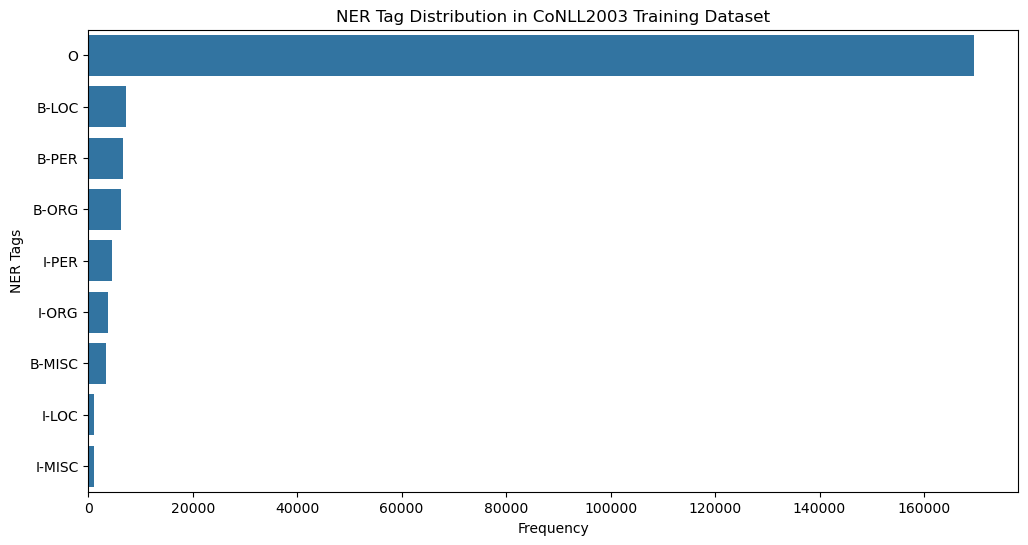

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Flatten the list of NER tags from all examples
train_ner_tags = [tag for example in dataset['train']['ner_tags'] for tag in example]

# Map NER tags to their names
train_ner_tags_named = [ner_tag_list[tag] for tag in train_ner_tags]

# Count the frequency of each NER tag
ner_tag_counts = Counter(train_ner_tags_named)

# Sort the tags by frequency
sorted_ner_counts = dict(sorted(ner_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the NER tag distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(sorted_ner_counts.values()), y=list(sorted_ner_counts.keys()), orient='h')
plt.title("NER Tag Distribution in CoNLL2003 Training Dataset")
plt.xlabel("Frequency")
plt.ylabel("NER Tags")
plt.show()


In [4]:
import pandas as pd

def visualize_sample_ner(dataset, sample_idx=0):
    sample = dataset['train'][sample_idx]
    
    tokens = sample['tokens']
    ner_tags = [ner_tag_list[tag] for tag in sample['ner_tags']]
    
    # Create a DataFrame for easy visualization
    df = pd.DataFrame({
        'Token': tokens,
        'NER Tag': ner_tags
    })
    
    print(f"Sample {sample_idx} Visualization:")
    display(df)
    return df

# Visualize a sample sentence
df_sample = visualize_sample_ner(dataset, sample_idx=4)


Sample 4 Visualization:


,Token,NER Tag
0,Germany,B-LOC
1,'s,O
2,representative,O
3,to,O
4,the,O
5,European,B-ORG
6,Union,I-ORG
7,'s,O
8,veterinary,O
9,committee,O


In [5]:
def highlight_named_entities(dataset, sample_idx=0):
    from termcolor import colored
    
    sample = dataset['train'][sample_idx]
    tokens = sample['tokens']
    ner_tags = [ner_tag_list[tag] for tag in sample['ner_tags']]
    
    sentence = ""
    for token, tag in zip(tokens, ner_tags):
        if tag != 'O':
            # Highlight named entities
            entity_type = tag.split('-')[-1]
            if entity_type == 'PER':
                color = 'green'
            elif entity_type == 'ORG':
                color = 'cyan'
            elif entity_type == 'LOC':
                color = 'blue'
            elif entity_type == 'MISC':
                color = 'magenta'
            else:
                color = 'grey'
            token_str = colored(token, color, attrs=['bold'])
            sentence += token_str + " "
        else:
            sentence += token + " "
    print(f"Sample {sample_idx} with Named Entities Highlighted:")
    print(sentence)

# Highlight named entities in a sample sentence
highlight_named_entities(dataset, sample_idx=0)


Sample 0 with Named Entities Highlighted:
EU rejects German call to boycott British lamb . 


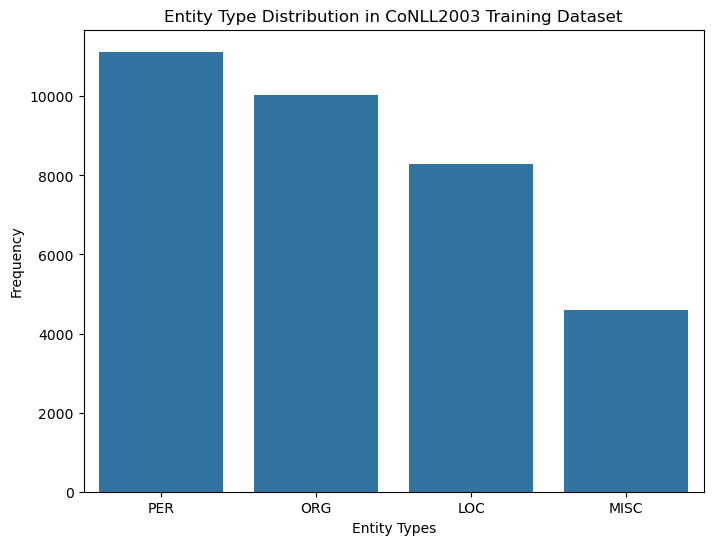

In [6]:
# Extract entity types without B- or I- prefixes
entity_types = [tag.split('-')[-1] for tag in train_ner_tags_named if tag != 'O']

# Count entity types
entity_type_counts = Counter(entity_types)

# Sort counts
sorted_entity_counts = dict(sorted(entity_type_counts.items(), key=lambda item: item[1], reverse=True))

# Plot entity type distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(sorted_entity_counts.keys()), y=list(sorted_entity_counts.values()))
plt.title("Entity Type Distribution in CoNLL2003 Training Dataset")
plt.xlabel("Entity Types")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from datasets import load_dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import numpy as np

# Load dataset
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                aligned_labels.append(label[word_idx])
            else:
                aligned_labels.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels,
    id2label={str(i): label for i, label in enumerate(label_list)},
    label2id={label: i for i, label in enumerate(label_list)}
)

# Training setup
data_collator = DataCollatorForTokenClassification(tokenizer)
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

metric = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[pred] for (pred, label) in zip(prediction, label) if label != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[label] for (pred, label) in zip(prediction, label) if label != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
